<a href="https://colab.research.google.com/github/ahmedSadoun/colab-project/blob/main/alexnet_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#load kaggle api
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
#download dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:20<00:00, 22.8MB/s]
100% 2.29G/2.29G [00:20<00:00, 118MB/s] 


In [ ]:
#extracte data from zipfile
import zipfile
zf = "/content/chest-xray-pneumonia.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
train_dir = '/content/dataset/cnn/pneumonia_revamped/chest_xray/train'
test_dir = '/content/dataset/cnn/pneumonia_revamped/chest_xray/test'
valid_dir = '/content/dataset/cnn/pneumonia_revamped/chest_xray/val'

In [ ]:
# Visualize Image before Image Augmentation
train_pneumonia_img = glob(train_dir+'/PNEUMONIA/*.jpeg') # Load all pneumonia images from train directory
train_normal_img = glob(train_dir+'/NORMAL/*.jpeg') # Load all normal images frin train directory

In [ ]:
pneumonia = np.asarray(plt.imread(train_pneumonia_img[0]))
normal = np.asarray(plt.imread(train_normal_img[0]))

(640, 824)


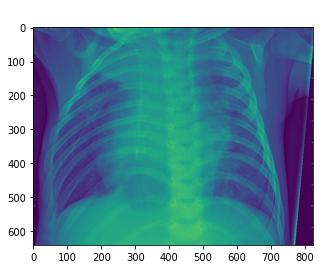

In [ ]:
plt.title('PNEUMONIA', fontsize=20, color='white')
plt.imshow(pneumonia)
print(pneumonia.shape) # print image size

(1812, 2114)


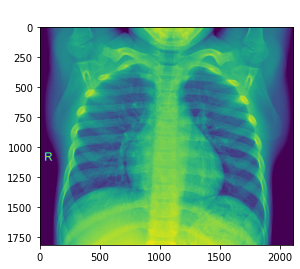

In [ ]:
plt.title('NORMAL', fontsize=20, color='white')
plt.imshow(normal)
print(normal.shape) # print image size

In [ ]:
# ImageDataGenerator for training and test
datagen = ImageDataGenerator(validation_split = 0.25, 
                             rescale=1./255, 
                             rotation_range = 30, 
                             zoom_range = 0.15, 
                             width_shift_range=0.15, 
                             height_shift_range=0.15, 
                             horizontal_flip=False,
                             vertical_flip=False)
# ImageDataGenerator for val set
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
IMG_SIZE = (227, 227)
train_set = datagen.flow_from_directory(train_dir, 
                                       
                                        class_mode='binary', 
                                        batch_size= 32,
                                        target_size=IMG_SIZE)

Found 5216 images belonging to 2 classes.


In [ ]:
valid_set = datagen.flow_from_directory(valid_dir, 
                                       
                                        class_mode='binary', 
                                        batch_size= 32,
                                        target_size=IMG_SIZE)

Found 16 images belonging to 2 classes.


In [ ]:
test_set = datagen.flow_from_directory(test_dir, 
                                      
                                        class_mode='binary', 
                                        batch_size= 32,
                                        target_size=IMG_SIZE)

Found 624 images belonging to 2 classes.


In [ ]:
X_train, y_train = train_set.next()
X_test, y_test = test_set.next()
print(len(X_train), len(y_train))

32 32


In [ ]:
print('Train X=%s Y=%s' %(X_train.shape, y_train.shape))
print('Test X=%s Y=%s' %(X_test.shape, y_test.shape))

Train X=(32, 227, 227, 3) Y=(32,)
Test X=(32, 227, 227, 3) Y=(32,)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


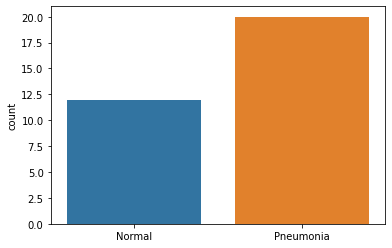

In [ ]:
labels = ['Normal' if label == 0 else 'Pneumonia' for label in y_train]
sns.countplot(labels)

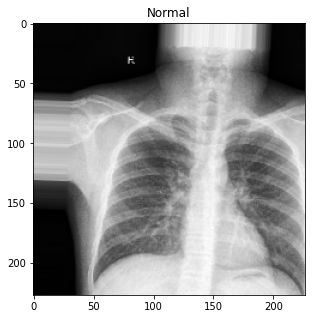

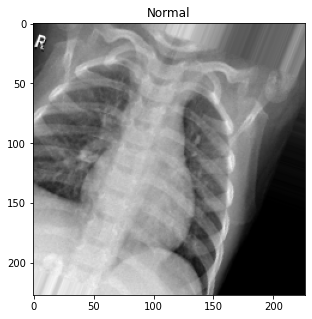

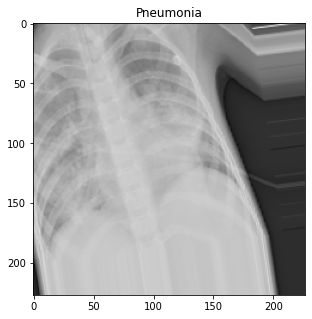

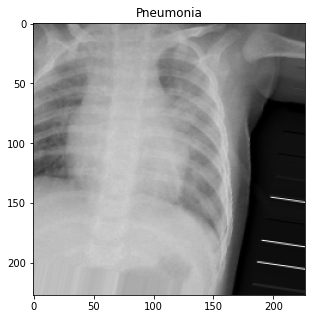

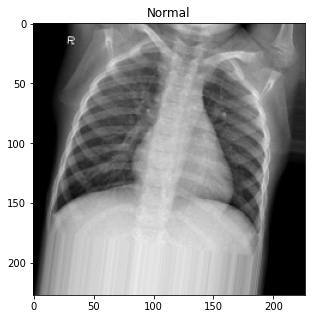

In [ ]:
for idx in range(5):
    plt.figure(figsize=(5, 5))
    plt.imshow(X_train[idx])
    plt.title(labels[idx])

In [ ]:
X_train[0].shape

(227, 227, 3)

In [ ]:
# Create callbacks for our model

# Create checkpoint callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('model_alex_net.h5') 

# Create Custom callback
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.93 and logs.get('val_accuracy') > 0.93) and (logs.get('loss')<= 0.3 and logs.get('val_loss') <= 0.3):
            if logs.get('accuracy') <= logs.get('val_accuracy'):
                self.model.stop_training = True
            else:
                self.model.stop_training = False
#             if(logs.get('accuracy') > 0.94 and logs.get('val_accuracy') > 0.94) and (logs.get('loss')<= 0.3 and logs.get('val_loss') <= 0.3):

custom_cb = CustomCallback()

In [ ]:
# Define alexNet model


model_alex_net = tf.keras.models.Sequential([
     # 1st conv layer                                        
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3),
                           padding='valid'),
    tf.keras.layers.BatchNormalization(),
    # Max pooling
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'),
    
    # # Dropout to prevent overfit
    # tf.keras.layers.Dropout(0.5),

    # 2nd conv layer
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),

    # Max pooling
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'),

    # # Dropout to prevent overfit
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    # 3rd conv layer
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    # 4th Conv layer
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    # 5th Conv layer
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    # Max Pooling
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    # Dropout to prevent overfit
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    # # Dropout to prevent overfit
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # Dropout to prevent overfit
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model_alex_net.compile(loss='categorical_crossentropy', optimizer =tf.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
early = EarlyStopping(monitor="loss", mode="min",min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

hist = model_alex_net.fit(
    train_set,
    validation_data = valid_set,
    epochs = 32,
    callbacks=[custom_cb, checkpoint_cb,callbacks_list]
)
model_alex_net.save('/content/drive/MyDrive/project models/AlexNet_final_save_v2.h5')

Epoch 1/32
163/163 [==============================] - 903s 6s/step - loss: 0.0000e+00 - accuracy: 0.8511 - val_loss: 0.0000e+00 - val_accuracy: 0.4375
Epoch 2/32
163/163 [==============================] - 894s 5s/step - loss: 0.0000e+00 - accuracy: 0.8732 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 3/32
 20/163 [==>...........................] - ETA: 12:55 - loss: 0.0000e+00 - accuracy: 0.8888

KeyboardInterrupt: ignored

In [ ]:
from tensorflow.python.keras.models import load_model

model = load_model('/content/drive/MyDrive/project models/AlexNet_final_save.h5')

In [ ]:
model_alex_net.save('/content/drive/MyDrive/project models/AlexNet_final_save.h5')

In [ ]:
from tensorflow.python.keras.models import load_model

model = load_model('/content/drive/MyDrive/project models/AlexNet_final_save.h5')
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
early = EarlyStopping(monitor="loss", mode="min",min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

hist = model_alex_net.fit(
    train_set,
    validation_data = valid_set,
    epochs = 32,
    callbacks=[custom_cb, checkpoint_cb,callbacks_list]
)

Epoch 1/32
163/163 [==============================] - 901s 6s/step - loss: 0.0000e+00 - accuracy: 0.8754 - val_loss: 0.0000e+00 - val_accuracy: 0.5000
Epoch 2/32
104/163 [==================>...........] - ETA: 5:24 - loss: 0.0000e+00 - accuracy: 0.8589

In [ ]:

#nb_samples = test_dir.shape[0]
predict = model.predict(test_set)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

score, acc = model.evaluate(test_set,
                            batch_size=8)
print('Test score:', score)
print('Test accuracy:', acc)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
print('f1 score ',f1_score(predict.round(),test_set.classes,average='micro'))
print('accuracy ',accuracy_score(predict.round(),test_set.classes))
print('recall ',recall_score(predict.round(),test_set.classes,average=None))
print('precision ',precision_score(predict.round(),test_set.classes,average=None))

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fprValue2, tprValue2, thresholdsValue2 = roc_curve(test_set.classes,predict.round())
AUCValue = auc(fprValue2, tprValue2)
print('AUC Value  : ', AUCValue)
plt.title('Receiver Operating Characteristic')
plt.plot(fprValue2, tprValue2, label='AUC = %0.4f'% AUCValue)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [ ]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
precision, recall, _ = precision_recall_curve(test_set.classes, predict.round())
# plot the model precision-recall curve
pyplot.plot(recall, precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test_set.classes, predict.round()),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")